# Simulations on Real Data from Fairhaven/New Bedford Deployment

In [43]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain
import ipp_library

# necessary imports
import pandas as pd
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns
from descartes import PolygonPatch
from shapely.geometry import LineString
from scipy.optimize import curve_fit
# import sensor_plotting as sp

%matplotlib inline
%pylab inline

pd.set_option('display.max_columns',None)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

Populating the interactive namespace from numpy and matplotlib


In [46]:
all_data = './jetyak_new_bedford/cleandata/all_interpolated.csv'
fh_data = './jetyak_new_bedford/cleandata/fh_interpolated.csv'
nb_data = './jetyak_new_bedford/cleandata/nb_interpolated.csv'

ctd_geo = './jetyak_new_bedford/cleandata/ctd_geo.csv'
gga_geo = './jetyak_new_bedford/cleandata/gga_geo.csv'
nit_geo = './jetyak_new_bedford/cleandata/nit_geo.csv'
op_geo = './jetyak_new_bedford/cleandata/op_geo.csv'
air_geo = './jetyak_new_bedford/cleandata/air_geo.csv'

'''
all_data = '../nb-effluent-plumes/data/clean/all_interpolated.csv'
fh_data = '../nb-effluent-plumes/data/clean/fh_interpolated.csv'
nb_data = '../nb-effluent-plumes/data/clean/nb_interpolated.csv'

ctd_geo = '../nb-effluent-plumes/data/clean/ctd_geo.csv'
gga_geo = '../nb-effluent-plumes/data/clean/gga_geo.csv'
nit_geo = '../nb-effluent-plumes/data/clean/nit_geo.csv'
op_geo = '../nb-effluent-plumes/data/clean/op_geo.csv'
air_geo = '../nb-effluent-plumes/data/clean/air_geo.csv'
'''


"\nall_data = '../nb-effluent-plumes/data/clean/all_interpolated.csv'\nfh_data = '../nb-effluent-plumes/data/clean/fh_interpolated.csv'\nnb_data = '../nb-effluent-plumes/data/clean/nb_interpolated.csv'\n\nctd_geo = '../nb-effluent-plumes/data/clean/ctd_geo.csv'\ngga_geo = '../nb-effluent-plumes/data/clean/gga_geo.csv'\nnit_geo = '../nb-effluent-plumes/data/clean/nit_geo.csv'\nop_geo = '../nb-effluent-plumes/data/clean/op_geo.csv'\nair_geo = '../nb-effluent-plumes/data/clean/air_geo.csv'\n"

In [47]:
all_df = pd.read_table(all_data, delimiter=',', header=[0,1])
fh_df = pd.read_table(fh_data, delimiter=',', header=[0,1])
nb_df = pd.read_table(nb_data, delimiter=',', header=[0,1])

ctd_df = pd.read_table(ctd_geo, delimiter=',', header=[0,1])
gga_df = pd.read_table(gga_geo, delimiter=',', header=[0,1])
nit_df = pd.read_table(nit_geo, delimiter=',', header=[0,1])
air_df = pd.read_table(air_geo, delimiter=',', header=[0,1])
op_df = pd.read_table(op_geo, delimiter=',', header=[0,1])

(1458, 2) (1458, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s34  0010   4.925185e+03   1.266206e+03 
    06s75  0031   4.773194e+03   7.400217e-01 
    08s20  0038   4.772501e+03   4.100327e-09 
Runtime:     08s20
Optimization status: Converged

Optimization restart 1/2, f = 4772.50086267
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s22  0008   9.928151e+02   1.730335e+04 
    06s86  0026   8.445479e+02   1.363427e-06 
    07s11  0027   8.445479e+02   1.363427e-06 
Runtime:     07s11
Optimization status: Converged

Optimization restart 2/2, f = 844.54791189
  rbf.         |          value  |  constraints  |  priors
  variance     |  12.9328718579  |      +ve      |        
  lengthscale  |  4.10035182808  |      +ve      |        


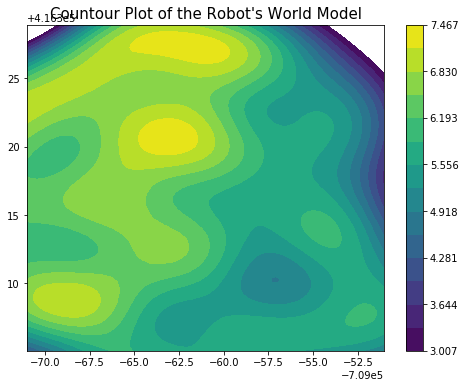

In [48]:
fh_d = fh_df.loc[fh_df['p'].drop_duplicates(subset=['Longitude']).dropna().index]
fh_d = fh_d.loc[fh_d['gga'].dropna(subset=['CO2_ppm_adjusted']).index]
fh_d = fh_d[fh_d['p']['Latitude'] < 41.634]
fh_d = fh_d[fh_d['p']['Latitude'] > 41.6305]
fh_d = fh_d[fh_d['p']['Longitude'] > -70.9071]
fh_d = fh_d[fh_d['ctd']['Depth'] > 0.2]
fh_d = fh_d[fh_d['ctd']['Depth'] < 0.5]
fh_d = fh_d[fh_d['gga']['CH4_ppm_adjusted'] < 8.5]


# ctd_fh = ctd_df.drop(ctd_df[ctd_df.Julian_Date > (0.205+2458207)].index)
# ctd_nb = ctd_df.drop(ctd_df[ctd_df.Julian_Date < (0.231+2458207)].index)
# fh_d = fh_d.dropna()

xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

# plt.scatter(xv*100, yv*100)

ranges = [min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000]

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape

kern = GPy.kern.RBF(input_dim = 2, lengthscale=0.001, variance=np.var(z))
mod = GPy.models.GPRegression(xvals, zvals, kern)
mod.initialize_parameter()
mod.optimize_restarts(num_restarts = 2, messages = True)
print kern

xc = np.linspace(ranges[0], ranges[1], 100)
yc = np.linspace(ranges[2], ranges[3], 100)
xc, yc = np.meshgrid(xc, yc, sparse = False, indexing= 'xy')
data = np.vstack([xc.ravel(), yc.ravel()]).T
obs, var = mod.predict(data, full_cov=False, include_likelihood=True)

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_xlim(ranges[0:2])
ax2.set_ylim(ranges[2:])       
ax2.set_title('Countour Plot of the Robot\'s World Model')     
plot = ax2.contourf(xc, yc, obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
# ax2.scatter(xc, yc, c=obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
ax2.scatter(xv, yv, c=z, cmap='viridis', vmin=min(z), vmax=max(z))
ax2.plot(-70.90668, 41.63118, 'r*', markersize=10)
cbar = fig2.colorbar(plot)

In [ ]:
reload(ipp_library)
from ipp_library import *

# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

LENGTH = 4.1050775778369463
VAR = 13.183938289650506

# plt.scatter(xv*100, yv*100)

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape
print max(xv)*10000 - min(xv)*10000, max(yv)*10000 - min(yv)*10000
print np.mean(zvals), np.var(zvals)

ranges = (min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000)

reward_function = 'mes'
gp_world = GPModel(ranges, LENGTH, VAR)
gp_world.add_data(xvals, zvals)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = VAR, 
                    lengthscale = LENGTH, 
                    visualize = True,
                    seed = None,
                    model = gp_world)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(-709070.99900000007, -709051.0340000001, 20)
x2observe = np.linspace(416305.07100000005, 416328.92400000006, 20)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

print ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              #prior_dataset =  (data, observations), 
              init_lengthscale = LENGTH, 
              init_variance = VAR, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 3.0, 
              turning_radius = 0.05,
              sample_step = 1.0,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 175)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()


(1458, 2) (1458, 1)
19.965 23.853
6.3706577657 0.333017618988
World max value 7.46737439696 at location [-709064.919  416322.422]
(-709061.01650000014, 416316.99750000006, 0)
[ 0 ] Current Location:   (-709061.01650000014, 416316.99750000006, 0)
Number of rollouts: 5060 	 Size of tree: 19149
Current predicted max and value: 	[[ 0.  0.]] 	0.0
[ 1 ] Current Location:   (-709063.12463923043, 416314.86307994166, -2.3500000000000001)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 12.15971497]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 10.91159608]
Number of rollouts: 3607 	 Size of tree: 10546
Current predicted max and value: 	[-709062.73762069  416315.76372414] 	6.31848832384
[ 2 ] Current Location:   (-709062.14129519148, 416312.02881910308, -1.236842105263158)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 9.82967241]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 18.7031918]
Number of rollouts: 275 	 Siz

Number of rollouts: 287 	 Size of tree: 1203
Current predicted max and value: 	[-709062.73762069  416323.16637931] 	7.25271574087
[ 22 ] Current Location:   (-709066.17886324669, 416313.80972806783, 8.1631578947368464)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 7.10446866]
Max observed is bigger than max in opt: [ 7.15395262]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.45735501]
Number of rollouts: 288 	 Size of tree: 1151
Current predicted max and value: 	[-709062.73762069  416323.16637931] 	7.2449855135
[ 23 ] Current Location:   (-709065.26584522834, 416316.66741911101, 7.5447368421052676)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 7.17547327]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.86348626]
Number of rollouts: 257 	 Size of tree: 1043
Current predicted max and value: 	[-709062.73762069  416323.16637931] 	7.27777149959
[ 24 ] Current Location:   (-709064.71235266735, 416319.6159180

Max Value in Optimization 	 	[ 7.27642747]
Max observed is bigger than max in opt: [ 7.3073427]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.29302362]
Max observed is bigger than max in opt: [ 7.3073427]
Number of rollouts: 272 	 Size of tree: 1141
Current predicted max and value: 	[-709061.36072414  416327.27896552] 	7.13957751457
[ 43 ] Current Location:   (-709061.79109306738, 416323.86704247748, -1.8552631578947307)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 7.28782521]
Max observed is bigger than max in opt: [ 7.3073427]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.9428765]
Number of rollouts: 260 	 Size of tree: 1078
Current predicted max and value: 	[-709061.36072414  416327.27896552] 	7.14498164546
[ 44 ] Current Location:   (-709062.98183185549, 416321.11347367708, -1.9789473684210466)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 7.28441822]
Max observed is bigger than max in opt: [ 7

Number of rollouts: 253 	 Size of tree: 1065
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.21558086555
[ 61 ] Current Location:   (-709062.72206735495, 416320.93171639211, -20.407894736842099)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 7.28399539]
Max observed is bigger than max in opt: [ 7.31588511]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.28357952]
Max observed is bigger than max in opt: [ 7.31588511]
Number of rollouts: 255 	 Size of tree: 1049
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.21862879456
[ 62 ] Current Location:   (-709064.88258328498, 416323.01310316921, -22.757894736842101)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 7.28464418]
Max observed is bigger than max in opt: [ 7.31731321]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.2820924]
Max observed is bigger than max in opt: [ 7.31731321]
Number of rollouts: 227 	 Siz

Max Value in Optimization 	 	[ 7.9474847]
Number of rollouts: 239 	 Size of tree: 978
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.22817781868
[ 79 ] Current Location:   (-709063.77902292588, 416320.8603401843, -37.228947368421053)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 8.59759723]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.27754517]
Max observed is bigger than max in opt: [ 7.31784011]
Number of rollouts: 232 	 Size of tree: 1020
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.22871387704
[ 80 ] Current Location:   (-709062.38780588575, 416323.51825574867, -36.610526315789471)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 7.27761358]
Max observed is bigger than max in opt: [ 7.31784011]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.28221042]
Max observed is bigger than max in opt: [ 7.31784011]
Number of rollouts: 235 	 Size of tree: 99

Number of rollouts: 190 	 Size of tree: 828
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.23592834412
[ 97 ] Current Location:   (-709065.58524666587, 416319.64767264063, -59.492105263157896)
Starting global optimization 0 of 2
Max Value in Optimization 	 	[ 7.51496535]
Starting global optimization 1 of 2
Max Value in Optimization 	 	[ 7.28027886]
Max observed is bigger than max in opt: [ 7.31888433]
Number of rollouts: 212 	 Size of tree: 903
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.23617980616
[ 98 ] Current Location:   (-709064.60267960397, 416322.48220293131, -61.594736842105263)
Starting global optimization 0 of 2
